In [2]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd
import datetime 

#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 9)   # Change the size of plots

Populating the interactive namespace from numpy and matplotlib


In [3]:
start_date = datetime.datetime(2007, 1, 1)
end_date = datetime.datetime(2019, 12, 7)
aapl = pdr.get_data_yahoo('AAPL', start=start_date, end=end_date)

In [4]:
aapl.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-02,268.250000,263.450012,267.269989,264.160004,23621800.0,264.160004
2019-12-03,259.529999,256.290009,258.309998,259.450012,28607600.0,259.450012
2019-12-04,263.309998,260.679993,261.070007,261.739990,16795400.0,261.739990
2019-12-05,265.890015,262.730011,263.790009,265.579987,18606100.0,265.579987
2019-12-06,271.000000,267.299988,267.480011,270.709991,26518900.0,270.709991


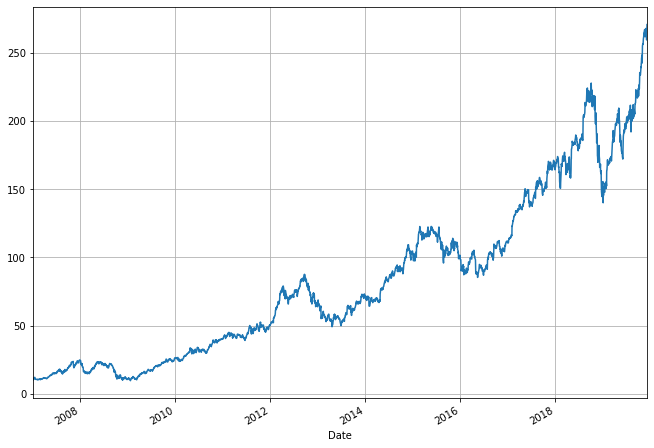

In [5]:
f, ax = plt.subplots(figsize=(11,8))

aapl['Adj Close'].plot(grid = True) # Plot the adjusted closing price of AAPL


In [6]:
# Fast moving window rolling mean
aapl['fast'] = aapl['Adj Close'].rolling(window=2).mean()
# Short moving window rolling mean
aapl['slow'] = aapl['Adj Close'].rolling(window=8).mean()


In [7]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

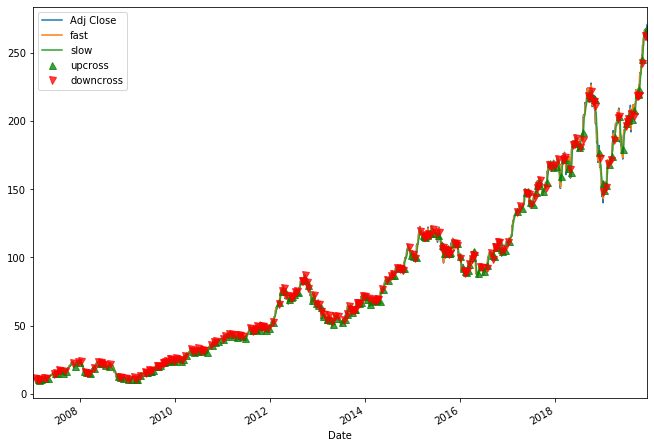

In [8]:
up = get_up_cross(aapl)
down = get_down_cross(aapl)

f, ax = plt.subplots(figsize=(11,8))

# Plot the adjusted closing price, the short and long windows of rolling means
aapl[['Adj Close', 'fast', 'slow']].plot(ax=ax, grid=True)

up.plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [9]:
display(len(up.index), len(down.index))

221

221

In [10]:
# Creates a labebls
side_up = pd.Series(1, index=up.index).dropna()
side_down = pd.Series(-1, index=down.index).dropna()
side = pd.concat([side_up,side_down]).sort_index()
display(side[:5], side.shape)

Date
2007-01-18   -1
2007-02-07    1
2007-02-09   -1
2007-02-13    1
2007-02-16   -1
dtype: int64

(442,)

In [11]:
crossEvents = side.index
crossEvents.values

array(['2007-01-18T00:00:00.000000000', '2007-02-07T00:00:00.000000000',
       '2007-02-09T00:00:00.000000000', '2007-02-13T00:00:00.000000000',
       '2007-02-16T00:00:00.000000000', '2007-02-20T00:00:00.000000000',
       '2007-02-27T00:00:00.000000000', '2007-03-06T00:00:00.000000000',
       '2007-03-29T00:00:00.000000000', '2007-04-04T00:00:00.000000000',
       '2007-04-10T00:00:00.000000000', '2007-04-23T00:00:00.000000000',
       '2007-06-12T00:00:00.000000000', '2007-06-18T00:00:00.000000000',
       '2007-06-26T00:00:00.000000000', '2007-07-03T00:00:00.000000000',
       '2007-07-24T00:00:00.000000000', '2007-07-26T00:00:00.000000000',
       '2007-07-31T00:00:00.000000000', '2007-08-21T00:00:00.000000000',
       '2007-09-07T00:00:00.000000000', '2007-09-13T00:00:00.000000000',
       '2007-11-08T00:00:00.000000000', '2007-11-20T00:00:00.000000000',
       '2007-12-17T00:00:00.000000000', '2007-12-21T00:00:00.000000000',
       '2008-01-03T00:00:00.000000000', '2008-02-01

In [12]:
adj_close = aapl['Adj Close']
adj_close[:5]

Date
2007-01-03    10.416352
2007-01-04    10.647548
2007-01-05    10.571726
2007-01-08    10.623935
2007-01-09    11.506466
Name: Adj Close, dtype: float64

In [13]:

def metaLabling(close, startEvents, side, verticalBarrier , SL = 0.010, TP = 0.015):
    
    
    """
    Meta Labling Funcion:
    ====================
    params : 
        - close : numpy_array
        - start events : numpy_array (Cross evet)
        - side : numpy_array
        - verticalBarrier:
        - Stop Loss : SL 
        - Take Profit : TP

    returns :
        - first touched level 
        - row return 
        - percent return 
        - side of the position
    """
    
    if verticalBarrier is None:
        verticalBarrier = pd.Series(close.index[-1], index=startEvents)


    ret = pd.DataFrame(columns=['touch_tp', 'raw_return', 'p_return', 'side'], index=startEvents)
    t_touch = 0
    r_ret = 0
    p_ret = 0
    
    for t0 in tqdm(startEvents):
   # for t0 in startEvents:
        window = close[t0:verticalBarrier[t0]]
        
        if(side[t0] == 1):
            trgHi = close[t0] * TP  # 1.5% * Close 200 * .015 =>  3 $ 
            trgLow = close[t0] * SL # 1% * Close 200*.01  => 2 $
        else:
            trgHi = close[t0] * SL # 1% * Close
            trgLow = close[t0] * TP # 1.5% * Close
        
        fabove = window >= (trgHi+close[t0]) # Higher Than Highest : [True,False,False,True,...] 203$ ?
        fbelow = window <= (close[t0]-trgLow)# Lower Than Lowest : [True,False,False,True,...] 198 ?
        
        hiTouch = window[fabove].index.min()
        lowTouch = window[fbelow].index.min()
        
        #print('ht',(hiTouch))
        #print('lt',(lowTouch))
        
        if ((pd.isnull(hiTouch)) and (pd.isnull(lowTouch))):
            #display('vertical barrier or infinit')
            t_touch = 0
            r_ret = close[verticalBarrier[t0]]
            
        elif (pd.isnull(hiTouch) and (not pd.isnull(lowTouch))):
            #display('low touch')
            t_touch = -1 
            r_ret = close[lowTouch]
        elif (not pd.isnull(hiTouch) and (pd.isnull(lowTouch))):
            #display('hi touch')
            t_touch = 1 
            r_ret = close[hiTouch]
        elif(hiTouch < lowTouch):
            #display('HI')
            t_touch = 1
            r_ret = close[hiTouch]
        else:
           # display('LOW')
            t_touch = -1
            r_ret = close[lowTouch]

            
        ret.loc[t0].touch_tp = t_touch * side[t0]
        ret.loc[t0].raw_return = abs(r_ret - close[t0]) * ret.loc[t0].touch_tp
        ret.loc[t0].p_return = abs(r_ret / close[t0] - 1 ) * ret.loc[t0].touch_tp
        ret.loc[t0].side = side[t0]

        
    return ret
    

In [14]:
df_met = metaLabling(adj_close, crossEvents, side, None, 0.10, 0.25)
df_met.head(10)

100%|██████████| 442/442 [00:01<00:00, 403.28it/s]


,touch_tp,raw_return,p_return,side
Date,,,,
2007-01-18,-1,-1.21441,-0.109689,-1
2007-02-07,1,2.80794,0.262217,1
2007-02-09,-1,-1.31758,-0.127297,-1
2007-02-13,1,2.75698,0.261865,1
2007-02-16,-1,-1.12367,-0.106566,-1
2007-02-20,1,2.83901,0.26589,1
2007-02-27,-1,-1.23554,-0.118432,-1
2007-03-06,1,2.9571,0.269758,1
2007-03-29,-1,-1.26413,-0.10848,-1


In [15]:
aapl_f = pd.merge(aapl, df_met, left_index=True, right_index=True)
aapl_f.shape

(442, 12)

In [16]:
display("before:", aapl_f.touch_tp.value_counts())
f = aapl_f.raw_return < 0.10
aapl_f.loc[f,'touch_tp'] = 0
f = aapl_f.touch_tp == -1
aapl_f.loc[f,'touch_tp'] = 0
aapl_f[f].head()
display("after:", aapl_f.touch_tp.value_counts())

'before:'

-1    268
 1    166
 0      8
Name: touch_tp, dtype: int64

'after:'

0    276
1    166
Name: touch_tp, dtype: int64

In [17]:
X = aapl_f[['Volume', 'Adj Close', 'fast', 'slow', 'side']]
y = aapl_f.touch_tp
X.shape

(442, 5)

## Tensroflow

In [18]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("TensorFlow version: ", tf.__version__)
#assert version.parse(tf.__version__).release[0] >= 2, \
#"This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xs, np.array(y), test_size=0.10, random_state=42, shuffle=False)


In [27]:
Xs

array([[ 5.20617838, -1.22576198, -1.22015191, -1.21764618, -1.        ],
       [ 1.72204676, -1.23164184, -1.23397036, -1.23417546,  1.        ],
       [ 1.16823812, -1.23744112, -1.23482645, -1.23468924, -1.        ],
       ...,
       [-0.85959362,  2.87633552,  2.89431853,  2.88333464,  1.        ],
       [-0.8348333 ,  2.79792841,  2.83719417,  2.87595929, -1.        ],
       [-0.85726331,  2.98033813,  2.93993686,  2.89190531,  1.        ]])

In [22]:
from datetime import datetime


logdir = "logs/scalars/" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+'_StockPrediction_200_Model-3'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
#EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
TerminateOnNaN = keras.callbacks.TerminateOnNaN()

model = keras.models.Sequential([
keras.layers.Dense(5, activation='relu',input_shape=(5,)),
keras.layers.Dense(10, activation='relu'),
keras.layers.Dense(5, activation='relu'),
keras.layers.Dense(1, activation='sigmoid'),
])


model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.load_weights('models/model-4/300EPC.h5')

In [78]:
model.fit(X_train, y_train, epochs=100, callbacks=[tensorboard_callback] , validation_split=0.1, shuffle=False , verbose=2)

Train on 357 samples, validate on 40 samples
Epoch 1/100
357/357 - 0s - loss: 0.4265 - acc: 0.8011 - val_loss: 0.5883 - val_acc: 0.8500
Epoch 2/100
357/357 - 0s - loss: 0.4247 - acc: 0.8039 - val_loss: 0.5888 - val_acc: 0.8500
Epoch 3/100
357/357 - 0s - loss: 0.4244 - acc: 0.8011 - val_loss: 0.5895 - val_acc: 0.8500
Epoch 4/100
357/357 - 0s - loss: 0.4242 - acc: 0.8011 - val_loss: 0.5901 - val_acc: 0.8500
Epoch 5/100
357/357 - 0s - loss: 0.4241 - acc: 0.8011 - val_loss: 0.5901 - val_acc: 0.8500
Epoch 6/100
357/357 - 0s - loss: 0.4240 - acc: 0.8011 - val_loss: 0.5905 - val_acc: 0.8500
Epoch 7/100
357/357 - 0s - loss: 0.4238 - acc: 0.8011 - val_loss: 0.5911 - val_acc: 0.8500
Epoch 8/100
357/357 - 0s - loss: 0.4237 - acc: 0.8011 - val_loss: 0.5916 - val_acc: 0.8500
Epoch 9/100
357/357 - 0s - loss: 0.4235 - acc: 0.8011 - val_loss: 0.5914 - val_acc: 0.8500
Epoch 10/100
357/357 - 0s - loss: 0.4234 - acc: 0.8011 - val_loss: 0.5916 - val_acc: 0.8500
Epoch 11/100
357/357 - 0s - loss: 0.4233 - a

In [79]:
model.save_weights('models/model-4/400EPC.h5')

In [80]:
model.evaluate(X_test, y_test)

45/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.553278398182657, 0.7777778]

In [25]:
predictions = model.predict(X_test)

In [81]:
# Export the model to a SavedModel
model.save('saved_model/2/',save_format="tf")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/2/assets


# Stock Prediction Deployment Model Via Docker

In [33]:
import json
import numpy
import requests
data = json.dumps({"signature_name": "serving_default",
                   "instances": X_test.tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/stock/versions/2:predict',
                              data=data, headers=headers)

new_predictions = numpy.array(json.loads(json_response.text)["predictions"])

In [34]:
new_predictions

array([[0.26791465],
       [0.01557103],
       [0.2872948 ],
       [0.01711464],
       [0.33225176],
       [0.0321871 ],
       [0.56732881],
       [0.05123338],
       [0.67823428],
       [0.15630648],
       [0.69526535],
       [0.07665071],
       [0.68093651],
       [0.04845008],
       [0.5672316 ],
       [0.04552558],
       [0.56677324],
       [0.03995338],
       [0.45722371],
       [0.01940781],
       [0.39353478],
       [0.02252582],
       [0.53273362],
       [0.02361691],
       [0.37760472],
       [0.02056935],
       [0.34955639],
       [0.01920041],
       [0.33912867],
       [0.02157921],
       [0.36488175],
       [0.01813239],
       [0.31703544],
       [0.01724917],
       [0.24632662],
       [0.01290321],
       [0.25629756],
       [0.01290098],
       [0.26189509],
       [0.00706396],
       [0.16110553],
       [0.00395274],
       [0.09270132],
       [0.00396113],
       [0.08850051]])